Shilpa Narayan <br>
Cost Matrix Dashboard <br>
Note: This imports the CourseProjectPart2_Shilpa_Narayan.ipynb file and uses HaitiPixels.csv as input

In [8]:
from IPython.display import HTML
#https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code."></form>''')

In [9]:
# imports and setup
# nbi:hide_in
import nbinteract as nbi
import numpy as np
import pandas as pd
import seaborn as sns
#import swifter
import warnings
import math
import time# to measure runtime of the algorithms
import itertools
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc, mean_squared_error, recall_score, precision_score,plot_confusion_matrix, f1_score, fbeta_score, plot_roc_curve, precision_recall_curve,plot_precision_recall_curve,average_precision_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV 
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_decision_regions
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

#Other global settings
sns.set() # will create pretty matplots
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor']= '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'
plt.rcParams['font.size']=12
warnings.filterwarnings('ignore')
pd.set_option('precision', 3) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.float_format', '{:20,.3f}'.format) # get rid of scientific notation
import nbimporter
import nbconvert
#importing already written functions from the main project file for this dashboard
from  CourseProjectPart2_Shilpa_Narayan import *

In [10]:
# nbi:hide_in
## Reading the training data
#Read CSV, look at data, check for nulls and categorize the Class variable in the data
hp = pd.read_csv("HaitiPixels.csv")
hp.Class = hp.Class.astype('category')
hp['Class'] = hp['Class'].astype('category')
#Create a new dummy variable for Blue Tarp or not 
hp['Tarp_Flag'] = ['Blue' if i == 'Blue Tarp' else 'Not Blue' for i in hp['Class']]
hp['Tarp_Flag'] = hp['Tarp_Flag'].astype('category')
#converting flag values to 1 and 0 for ease of use
hp['Tarp_Flag'] = np.where(hp['Class'].str.contains("Blue Tarp"), 1, 0)

## Setting global variables
random_state = 1;scoring = 'f1'
kf_10 = StratifiedKFold(n_splits=10,shuffle=True, random_state=random_state)
#split train/test and hold out data. Train/test data will be called just train across this program
x_sample1, x_sample2, y_sample, y_sample2 = train_test_split(hp[['Red','Green','Blue']], hp['Tarp_Flag'], train_size=0.20, random_state=random_state, shuffle=True)
#X_train = hp[['Red','Green','Blue']]; y_train = hp['Tarp_Flag']
#scale predictors 
X_train_sc = preprocessing.scale(x_sample1)
#initialize a table data frame to store the results
tab_tr = pd.DataFrame()
#Function to plot the important metrics which will help in making decisions
def plotMetrics(tab):
    f,(ax1,ax2) = plt.subplots(2,2,figsize=(15,10))
    tab = tab.rename(columns={'Logistic Regression':"Logistic"})
    tab.loc['Cost'].plot(marker='o',ax=ax1[0],title = 'Cost($)');
    tab.loc['Run-time'].plot(marker='o',ax=ax1[1],title = 'Run-time(minutes)', color='Blue');
    tab.loc['log-loss'].plot(marker='o',ax=ax2[0],title = 'log-loss (Lowest Better)', color='Red');
    tab.loc['AUC'].plot(marker='o',ax=ax2[1],title = 'AUC (Higher Better)', color='Green');
    plt.show()


__Three common values for the beta parameter are as follows:__

>$F0.5-Measure (beta=0.5):$ More weight on precision, less weight on recall

>$F1-Measure (beta=1.0):$ Balance the weight on precision and recall

>$F2-Measure (beta=2.0):$ Less weight on precision, more weight on recall


> TP = True Positives, FP = False Positives, TN = True Negatives, FN = False Negatives

<br><br>
__Enter costs per TP, FP, TN, FN and select a  beta value and click "Update"__



Dropdown(description='Beta:', index=1, options=(0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5), value=1.0)

Button(description='Update', style=ButtonStyle())

Output()

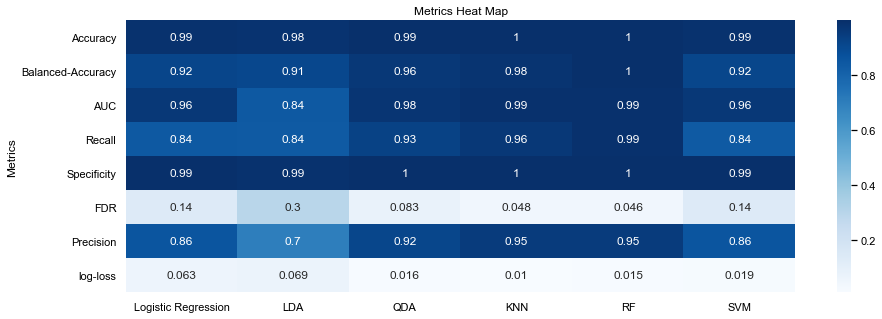

In [11]:
# nbi:hide_in
## Functions for fitting the data and plotting metrics
#https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/
def compareBeta(beta,cost_list):
    #cost_list=[tp,fp,tn,fn]
    print('Beta=',beta,', cost_list:',cost_list,'\n')
    start = time.time()
    lr = LogisticRegression(random_state=random_state,class_weight='balanced')
    lda1 = LinearDiscriminantAnalysis()
    qda1 = QuadraticDiscriminantAnalysis()
    knn1 = KNeighborsClassifier(n_neighbors=5)
    rf1 = RandomForestClassifier(random_state=random_state,min_samples_leaf=5, n_estimators=50, max_depth=15,oob_score=True,class_weight='balanced_subsample')
    svm1 = SVC(kernel='linear',random_state=random_state,C=40.01,tol=1e-05,class_weight='balanced',probability=True)
    #http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/
    labels = ['Logistic Regression', 'LDA','QDA', 'KNN', 'RF', 'SVM']
    for clf, lab, grd in zip([lr,lda1,qda1, knn1, rf1, svm1],labels,itertools.product([0, 1, 2], repeat=2)):
        fig = plt.figure(figsize=(10,5),constrained_layout=True)
        spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
        f_ax1 = fig.add_subplot(spec[0, 0])
        f_ax2 = fig.add_subplot(spec[0, 1])
        clf.fit(X_train_sc, y_sample)
        plt.subplot(spec[0, 0])
        threshold = float (callPrecision_Recall_Curve(f_ax1, clf,X_train_sc,y_sample,beta))
        plt.close()
        plt.subplot(spec[0, 1])
        metrics,cost_data = exploreConfusionMatrix(f_ax2,'train',clf,X_train_sc,y_sample,threshold)
        plt.close()
        #calculate the costs with the metrics
        cost = costAnalysis(cost_data,cost_list,str(lab),threshold)
        #end the algorthm time
        end = time.time()
        #calculate the total time taken in mins. Default is in seconds
        total_time = round((end - start)/60,1)
        tab_tr[str(lab)] = createFinalResultsTable(metrics, str(lab),total_time, cost['Cost'].sum())
    plotMetrics(tab_tr)
    plt.subplots(figsize=(15,5))
    plt.title('Metrics Heat Map')
    sns.heatmap(tab_tr.iloc[[0,1,2,4,5,6,7,8],:],annot=True,cmap='Blues')

#https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916
#https://medium.com/@jdchipox/how-to-interact-with-jupyter-33a98686f24e
#https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html
#https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
#https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/

#widget to enter True Positives cost
tp = widgets.BoundedFloatText(
    value=30,
    min=0,
    description='TP',
    width = 500,
    disabled=False
)
#widget to enter False  Positives cost
fp = widgets.BoundedFloatText(
    value=5,
    min=0,
    description='FP',
    width = 500,
    disabled=False
)
#widget to enter True Negatives cost
tn = widgets.BoundedFloatText(
    value=0,
    min=0,
    description='TN',
    width = 500,
    disabled=False
)
#widget to enter False Negatives cost
fn = widgets.BoundedFloatText(
    value=10,
    min=0,
    description='FN',
    width=500,
    disabled=False
)
##widget to select beta
beta = widgets.Dropdown(
    options=np.arange(0.5,4,0.5),
    value=1.0,
    description='Beta:',
    disabled=False,
)
#button to update costs and beta and ive metrics
btn = widgets.Button(description='Update')
#Dispaly text and interactive widgets
input_widgets1 = widgets.HBox([tp, fp])
input_widgets2 = widgets.HBox([tn, fn])
out = widgets.Output()#interactive_output(makeList, {'tp': tp, 'fp': fp, 'tn': tn, 'fn':fn})
def btn_eventhandler(change):
    with out:
        clear_output()
        cost_list=[tp.value,fp.value,tn.value,fn.value]
        compareBeta(beta.value,cost_list)
btn.on_click(btn_eventhandler)    
display(input_widgets1, input_widgets2,beta,btn,out)